<a href="https://colab.research.google.com/github/Zelkova46/AntColony_optimization/blob/main/penerapanACO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [14]:
import random
import itertools
import networkx as nx
import networkx.algorithms.shortest_paths.dense as nxalg
from typing import Tuple
import math
import datetime
import json
import logging
import time
import matplotlib.pyplot as plt
import numpy as np

# Penimplementasian TSP dengan membuat class yang memiliki fungsi yang bekerja untuk mencari jarak terpendek yang dapat di tempuh dari node asal ke node tujuan  

In [15]:
class TSP:
    """
    Creates a TSP problem with a certain number of nodes
    """

    def __init__(self, nodes: int = 30, dimensions: Tuple[int, int] = (1000, 10), seed=None):
        if seed:
            random.seed(seed)

        graph = nx.Graph()
        nodes_dict = dict()

        for i in range(nodes):
            nodes_dict[i] = (random.randint(0, dimensions[0]), random.randint(0, dimensions[1]))
            graph.add_node(i)

        for i, j in itertools.permutations(range(nodes), 2):
            graph.add_edge(i, j, weight=self.calculate_distance(nodes_dict[i], nodes_dict[j]))

        self.graph = graph
        self.nodes = nodes_dict
        self.distance_matrix = nxalg.floyd_warshall_numpy(graph)

    @staticmethod
    def calculate_distance(i, j):
        """
        Calculate the Euclidean distance between two nodes
        """
        return int(math.sqrt((i[0] - j[0])**2 + (i[1] - j[1])**2))


# Pengaplikasian ACO

In [17]:
class AntColonyOptimization:
    """
    Ant colony optimization algorithm for finding the shortest route in a graph.

    Parameters:
        m = number of ants
        k_max = number of iterations
        alpha = pheromone importance
        beta = distance importance
        rho = pheromone evaporation rate
        Q = pheromone deposit
        tau = pheromone
        eta = distance
    """
    def __init__(self, problem, **kwargs):
        self.graph = problem.graph
        self.nodes = list(problem.nodes)
        self.coordinates = list(problem.nodes.values())
        self.n = len(self.nodes)
        self.distance_matrix = problem.distance_matrix

        self.m = kwargs.get("m", 100)
        self.k_max = kwargs.get("k_max", 50)
        self.alpha = kwargs.get("alpha", 1)
        self.beta = kwargs.get("beta", 5)
        self.rho = kwargs.get("rho", 0.9)
        self.Q = kwargs.get("Q", 1)
        self.time_limit = kwargs.get("time_limit", 5)

        # initialization of tau and eta
        self.tau = np.full(self.distance_matrix.shape, 0.1)
        self.eta = 1 / (self.distance_matrix + 1e-10)

        self.history = []

    def ant_colony_optimization(self):
        """
        Ant colony optimization algorithm
        """
        start_time = time.time()
        x_best, y_best = [], float("inf")
        for _ in range(self.k_max):
            self.edge_attractiveness()
            self.tau *= (1-self.rho)
            for _ in range(self.m):
                x_best, y_best = self.ant_walk(x_best, y_best)
                if time.time() - start_time > self.time_limit:
                    logging.info("Time limit reached. Stopping ACO.")
                    return x_best, y_best
        return x_best, y_best

    def edge_attractiveness(self, plot: bool = False):
        """
        Calculate edge attractiveness
        tau = pheromone
        eta = distance
        alpha = pheromone importance
        beta = distance importance
        """
        self.A = (self.tau ** self.alpha) * (self.eta ** self.beta)

    def ant_walk(self, x_best, y_best, plot: bool = True):
        """
        Ant walk
        """
        x = [0]  # Start at the first node
        while len(x) < self.n:
            i = x[-1]
            neighbors = [j for j in range(self.n) if j not in x and self.distance_matrix[i][j] > 0]
            if len(neighbors) == 0:
                return x_best, y_best
            p = [self.A[(i, j)] for j in neighbors]
            sampled_neighbor = random.choices(neighbors, weights=p)[0]
            x.append(sampled_neighbor)
        x.append(0)
        y = self.score(x)
        self.history.append(y)
        for i in range(1, self.n):
            self.tau[(x[i-1], x[i])] += self.Q / y
        if y < y_best:
            logging.info("Better ACO solution found. Score: %.2f", y)
            return x, y
        return x_best, y_best

    def score(self, x):
        """
        Score a solution
        """
        y = 0
        for i in range(len(x) - 1):
            y += self.distance_matrix[x[i]][x[i + 1]]
        return y



# Penerapan ACO pada permasalahan Travelling Salesman Problem

Best Solution: [0, 25, 10, 14, 17, 23, 12, 11, 26, 22, 2, 13, 4, 21, 6, 24, 1, 18, 27, 19, 3, 9, 28, 29, 15, 8, 7, 5, 16, 20, 0]
Best Score: 1896.0


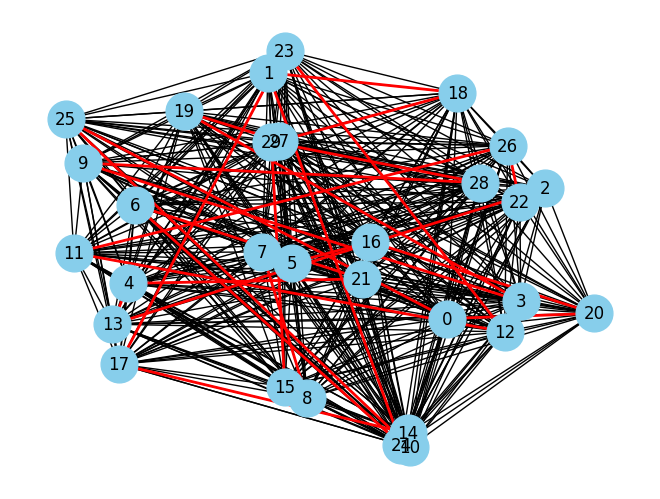

In [18]:

def plot_tsp_solution(graph, solution):
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=700, node_color='skyblue')
    nx.draw_networkx_edges(graph, pos, edgelist=[(solution[i], solution[i + 1]) for i in range(len(solution) - 1)], edge_color='r', width=2)
    nx.draw_networkx_edges(graph, pos, edgelist=[(solution[-1], solution[0])], edge_color='r', width=2)
    plt.show()


def main():
    problem = TSP()
    aco = AntColonyOptimization(problem)
    best_solution, best_score = aco.ant_colony_optimization()

    print("Best Solution:", best_solution)
    print("Best Score:", best_score)

    # Plot the graph with the best solution
    plot_tsp_solution(problem.graph, best_solution)


if __name__ == "__main__":
    main()

